# Lab time series analysis: COVID-19 data


In this lab assignment, we will make use of the COVID-19 dataset maintained by [Our World in Data](https://ourworldindata.org/coronavirus), published on Github at <https://github.com/owid/covid-19-data/tree/master/public/data>.

In [1]:
# Package imports for data science and time series analysis in particular
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd;
import scipy.stats as stats;
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

First, we import the dataset, parse the `date` column as the Python `DateTime` type and set this as the index:

In [2]:
covid19 = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', parse_dates=['date']).set_index(['date'])
covid19.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-04,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-05,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-06,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-07,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


Create a new `DataFrame` (with name e.g. `covid19_be`) that only contains the new cases in Belgium and use the `plot()` method of `DataFrame` to visualize it. Increase the size of the picture with the `figsize` parameter, otherwise it will be too small.

In [44]:
covid19_be = covid19[covid19.location == 'Belgium'][['new_cases']]
covid19_be.head()

,new_cases
date,
2020-01-03,0.0
2020-01-04,0.0
2020-01-05,0.0
2020-01-06,0.0
2020-01-07,0.0


<Axes: xlabel='date'>

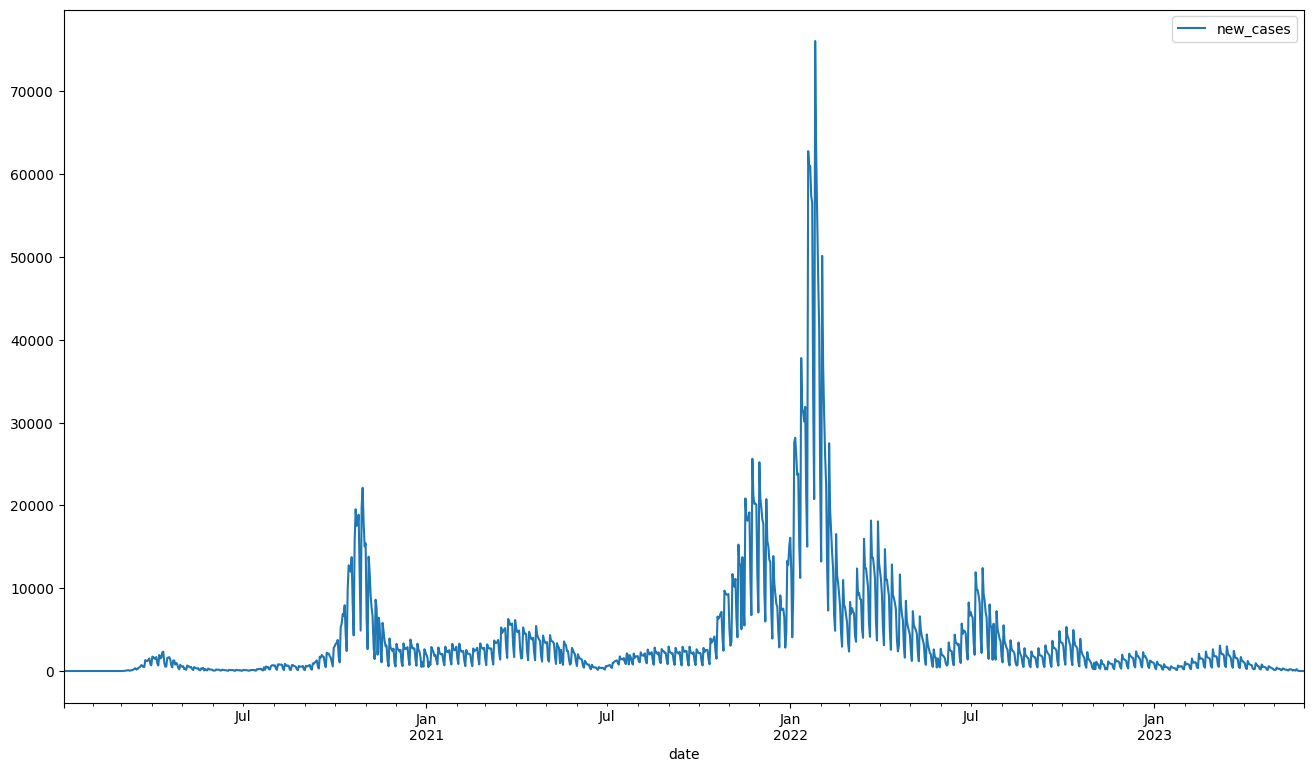

In [7]:
covid19_be.plot(y=['new_cases'], figsize=(16,9))

## Moving average

Add new columns to the data frame with new cases in Belgium with the simple moving average for 7 and 30 days. Plot the entire data frame (observations and both moving averages).

In [9]:
covid19_be['SMA7'] = covid19_be['new_cases'].rolling(7).mean()
covid19_be['SMA30'] = covid19_be['new_cases'].rolling(30).mean()
covid19_be.head(20)

,new_cases,SMA7,SMA30
date,,,
2020-01-03,0.0,NaN,NaN
2020-01-04,0.0,NaN,NaN
2020-01-05,0.0,NaN,NaN
2020-01-06,0.0,NaN,NaN
2020-01-07,0.0,NaN,NaN
2020-01-08,0.0,NaN,NaN
2020-01-09,0.0,0.0,NaN
2020-01-10,0.0,0.0,NaN
2020-01-11,0.0,0.0,NaN


## Holt-Winters model for new cases early 2021

The period from about December 2020 up to the end of February 2021 seems quite regular. Create a new `DataFrame` and select only the observations during that period (1 December 2020 to 28 February 2021). Plot the `DataFrame` (it will still contain the moving averages from the previous step).

In [19]:
extra = covid19_be[(covid19_be.index >= '2020-12-01') & (covid19_be.index <= '2021-02-28')] 
extra.head()

,new_cases,SMA7,SMA30
date,,,
2020-12-01,553.0,2296.285714,4490.266667
2020-12-02,3277.0,2203.571429,4388.933333
2020-12-03,2663.0,2178.142857,4389.533333
2020-12-04,2587.0,2170.000000,4015.600000
2020-12-05,2360.0,2164.857143,3692.666667


<Axes: xlabel='date'>

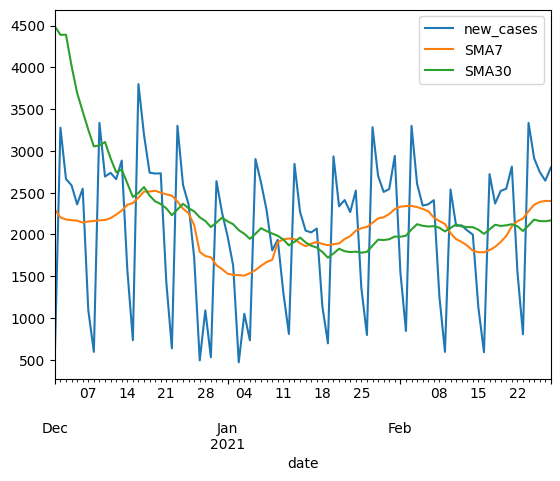

In [20]:
extra.plot()



Build a Holt-Winters model for the observed new cases during that period.

Use the additive type for both trend and seasonal smoothing. Set the value for `seasonal_periods` to the appropriate value! Plot the observed and fitted values.

<Axes: xlabel='date'>

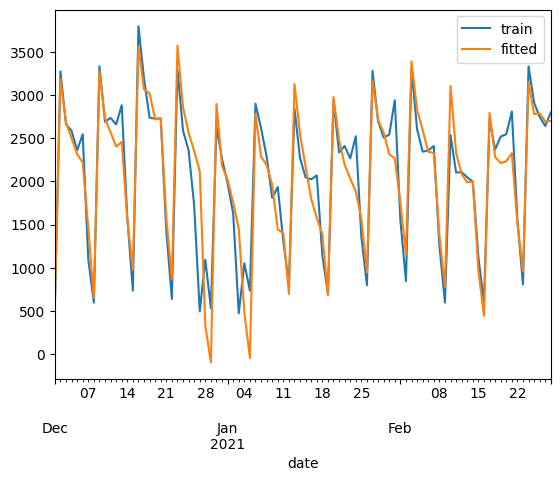

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = extra.new_cases


model = ExponentialSmoothing(train,
  trend='add', seasonal='add',
  seasonal_periods=7, freq='D').fit()

train.plot(legend=True, label='train')

model.fittedvalues.plot(legend=True, label='fitted')

Now, make a forecast for 21 days and plot observed and forecasted values. What do you notice when you compare observed and forecasted values as time progresses?

In [24]:
# Test data ophalen
test = covid19_be[(covid19_be.index >= '2021-03-01') & (covid19_be.index <= '2021-03-21')]['new_cases']
# Alternatieve manier
# test = covid19_be['2021-03-01':'2021-03-21]['new_cases']

Text(0.5, 1.0, 'Train, test, fitted & predicted values using Holt-Winters')

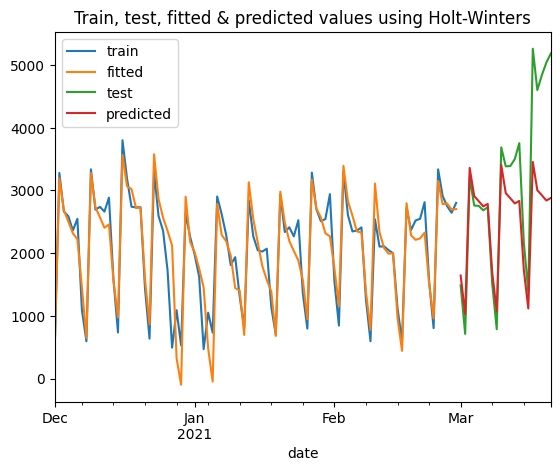

In [25]:
predicted = model.forecast(21)

train.plot(legend=True, label='train')
model.fittedvalues.plot(legend=True, label='fitted')

test.plot(legend=True, label='test')
predicted.plot(legend=True, label='predicted')

plt.title('Train, test, fitted & predicted values using Holt-Winters')

## Evaluating model quality


- Calculate the Mean Squared Error for a forecast period of 7 days, and compare its square root with the standard deviation of observed new cases over the test period and forecasted period combined.
- Do the same for a forecast period of 14 and 21 days.
- For which period is the quality of the forecast ok?

The expected results are shown in the table below:

|     Forecast period      |         MSE |     √MSE |    stdev |
| :----------------------: | ----------: | -------: | -------: |
| 2021-03-01 to 2021-03-07 |   25408.902 |  159.402 |  855.684 |
| 2021-03-01 to 2021-03-14 |  154280.817 |  392.786 |  895.531 |
| 2021-03-01 to 2021-03-21 | 1048835.781 | 1024.127 | 1052.978 |

In [27]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print(f'MSE 03-01 tot 03-07 = {mean_squared_error(test[0:7],predicted[0:7])}')
print(f'MSE 03-01 tot 03-14 = {mean_squared_error(test[0:14],predicted[0:14])}')
print(f'MSE 03-01 tot 03-21 = {mean_squared_error(test[0:21],predicted[0:21])}')


MSE 03-01 tot 03-07 = 25408.90161016752
MSE 03-01 tot 03-14 = 154280.81707120585
MSE 03-01 tot 03-21 = 1048835.7806246676


In [28]:
print(f'sqrt(MSE) 03-01 tot 03-07 = {np.sqrt(mean_squared_error(test[0:7],predicted[0:7]))}')
print(f'sqrt(MSE) 03-01 tot 03-14 = {np.sqrt(mean_squared_error(test[0:14],predicted[0:14]))}')
print(f'sqrt(MSE) 03-01 tot 03-21 = {np.sqrt(mean_squared_error(test[0:21],predicted[0:21]))}')

sqrt(MSE) 03-01 tot 03-07 = 159.40169889360502
sqrt(MSE) 03-01 tot 03-14 = 392.78596852637935
sqrt(MSE) 03-01 tot 03-21 = 1024.1268381527102


In [41]:
print(f"std(MSE) 03-01 tot 03-07 = {covid19_be['2021-03-01':'2021-03-07']['new_cases'].std()}")
print(f"std(MSE) 03-01 tot 03-14 = {covid19_be['2021-03-01':'2021-03-14']['new_cases'].std()}")
print(f"std(MSE) 03-01 tot 03-21 = {covid19_be['2021-03-01':'2021-03-21']['new_cases'].std()}")

std(MSE) 03-01 tot 03-07 = 890.1978645757571
std(MSE) 03-01 tot 03-14 = 1047.863939242512
std(MSE) 03-01 tot 03-21 = 1407.8773603921477


## ICU patients

Create a new `DataFrame` with only the total number of ICU (intensive care units) patients in the Belgian hospitals. Make sure that all NaN's are removed, since time series analysis functions can't cope with missing values. Plot this time series. 

<Axes: xlabel='date'>

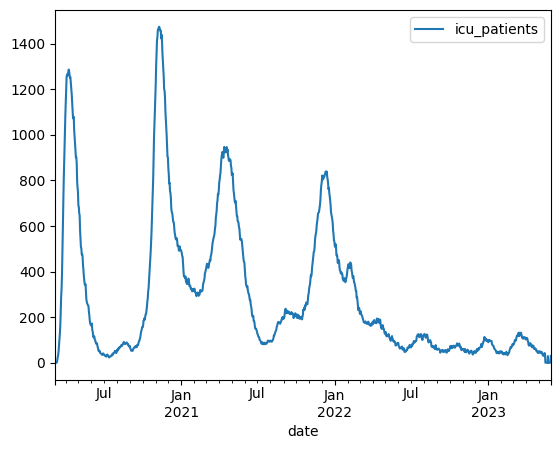

In [46]:
icu = covid19[covid19.iso_code == 'BEL'][['icu_patients']].dropna()
icu.head()
icu.plot()

Build a duible exponential smoothing (Holt) model of this time series. Make a forecast of 70 time units and plot the observations, fitted values and forecast.

Are we currently in an upward or downward trend, according to this model? Do the forecasted values seem reasonable if you look at the last period?

c:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python39\lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: xlabel='date'>

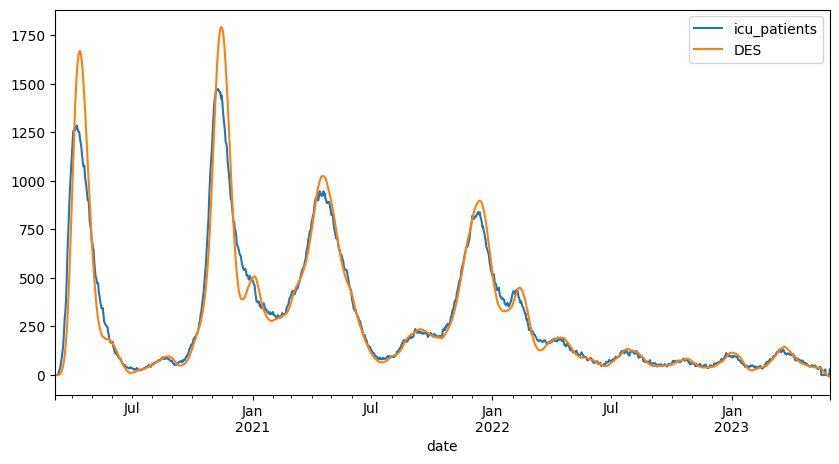

In [48]:
from statsmodels.tsa.api import Holt

data_des = Holt(icu['icu_patients']).fit(smoothing_level=.1, smoothing_trend=.2)

icu['DES'] = data_des.fittedvalues
icu.plot(y=['icu_patients',  'DES'], figsize=[10,5])

In [49]:
data_des.params_formatted

,name,param,optimized
smoothing_level,alpha,0.1,False
smoothing_trend,beta,0.2,False
initial_level,l.0,0.0,False
initial_trend,b.0,0.0,False


<Axes: xlabel='date'>

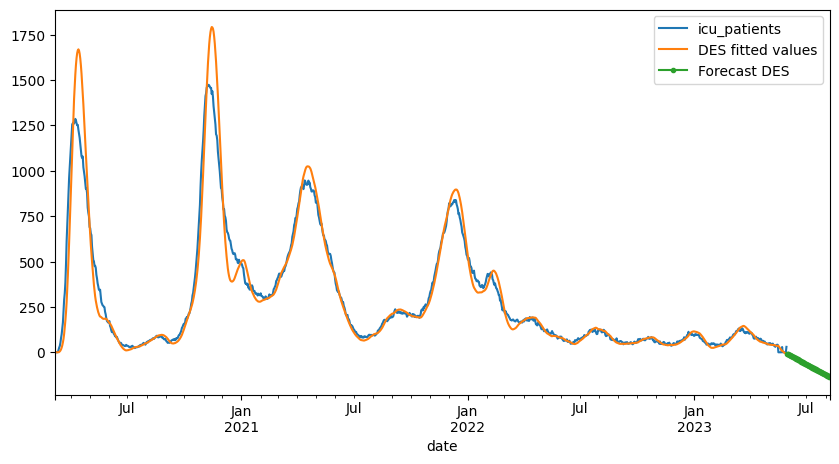

In [52]:
data_des_fcast = data_des.forecast(70)

icu['icu_patients'].plot(legend=True) # Observations
icu['DES'].plot(legend=True, label='DES fitted values', figsize=[10,5])              
data_des_fcast.plot(marker='.', legend=True, label='Forecast DES') 

Since we didn't set any initial parameters like $\alpha$ and $\beta$, the model calculated them using some rule of thumb. List these parameters from the model:

In [ ]:
data_des.params_formatted

What were the final estimated values for the level and trend, that are used in the forecast? In other words, what are the parameters of the line that estimates future observations?

In [54]:
laatste = len(data_des.level) - 1
print(f"laatste level = {data_des.level[laatste]}")
print(f"laatste trend = {data_des.trend[laatste]}")

laatste level= -6.153572984538718
laatste trend= -1.858532537781501


Let's try to set the parameters ourselves. Recreate the Holt-model with $\alpha = \beta = 0.1$. Calculate a forecast like before and plot.

c:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python39\lib\site-packages\pandas\util\_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: xlabel='date'>

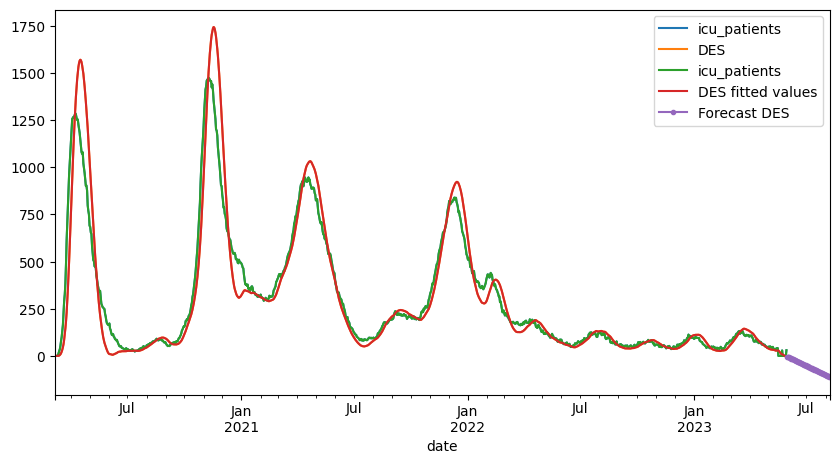

In [55]:
from statsmodels.tsa.api import Holt

data_des = Holt(icu['icu_patients']).fit(smoothing_level=.1, smoothing_trend=.1)

icu['DES'] = data_des.fittedvalues
icu.plot(figsize=[10,5])



data_des_fcast = data_des.forecast(70)

icu['icu_patients'].plot(legend=True) # Observations
icu['DES'].plot(legend=True, label='DES fitted values', figsize=[10,5])              
data_des_fcast.plot(marker='.', legend=True, label='Forecast DES') 

Compare the model parameters and final estimates. Which of the two forecast models seems to perform best if you look at the plots?

In [56]:
laatste = len(data_des.level) - 1
print(f"laatste level = {data_des.level[laatste]}")
print(f"laatste trend = {data_des.trend[laatste]}")

laatste level = -1.6423502331292354
laatste trend = -1.5754039911297697
